## Compositional Data and You

**Data** [Compositional Data](2_Data_CompositionalData.ipynb) | [Lambdas](2_Data_Lambdas.ipynb) **Classifiers** [Building Models](3_Classifiers_ClassifierModels.ipynb) | [Feature Selection](3_Classifiers_Features.ipynb) **Visualisation**  [Entropy](4_Vis_Entropy.ipynb) | [Manifolds](4_Vis_Manifolds.ipynb) **pyrolite** [Overview](6_pyrolite.ipynb) **GitHub** [AEGC2019](https://github.com/morganjwilliams/aegc2019) | [pyrolite](https://github.com/morganjwilliams/pyrolite)


For compositional data, everything is relative (thanks to the closure property), so we tend to use ratios to express differences or changes between things. However, if we make incorrect assumptions about the nature of our data, we can get some incorrect answers. Let's explore this a little by attempting to calcuate a simple mean of a ratio for a classic examle dataset from [Aitchison1984].

[Aitchison1984]: https://doi.org/10.1007/BF01029316 "Aitchison, J., 1984. The statistical analysis of geochemical compositions. Journal of the International Association for Mathematical Geology 16, 531–564. https://doi.org/10.1007/BF01029316"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyrolite.plot import pyroplot
# pyrolite comes with a few datasets from Aitchison (1984) built in which we can use
# as examples:
from pyrolite.data.Aitchison import load_kongite

df = load_kongite()

Say you want to know the average ratio between A and B:

In [2]:
A_on_B = df["A"] / df["B"]
A_on_B.mean()  # 2.8265837788402983

2.8265837788402983

Equally, you could have chosen to calculate the average ratio between B and A:

In [3]:
B_on_A = df["B"] / df["A"]
B_on_A.mean()  # 0.4709565704852008

0.4709565704852008

You expect these to be invertable, such that A/B = 1 / B/A, but not so:

In [4]:
A_on_B.mean() / (1 / B_on_A.mean())  # 1.3311982026717262

1.3311982026717262

Similarly, the relative variances are different:

In [5]:
np.std(A_on_B) / A_on_B.mean(), np.std(B_on_A) / B_on_A.mean()  # 0.6295146309597085, 0.5020948201979953

(0.6295146309597085, 0.5020948201979953)

This improves when using logratios in place of simple ratios, prior to exponentiating means; the logratios are invertible:

In [6]:
logA_on_B = (df["A"] / df["B"]).apply(np.log)
logB_on_A = (df["B"] / df["A"]).apply(np.log)

np.exp(logA_on_B.mean()), 1 / np.exp(logB_on_A.mean())    # 2.4213410747400514,  2.421341074740052

(2.4213410747400514, 2.421341074740052)

The logratios also have the same variance:

In [7]:
(np.std(logA_on_B) / logA_on_B.mean()) ** 2, (np.std(logB_on_A) / logB_on_A.mean()) ** 2  # 0.36598579018127086,  0.36598579018127086

(0.36598579018127086, 0.36598579018127086)

These peculiarities result from incorrect assumptions regarding the distribution of the data: ratios of compositional components are typically lognormally distributed, rather than normally distributed, and the compositional components themselves commonly have a Poisson distribution . These distributions contrast significantly with the normal distribution at the core of most statistical tests. 

We can compare distributions with similar means and variances but different forms, and note that the normal distribution has one immediate failure, in that it has non-zero probability density below 0, and we know that you can’t have negative atoms!

<img src="https://pyrolite.readthedocs.io/en/develop/_images/CompositionalDistributions.png" width="65%"/>

The form of these distributions is a reflection of the fact that geochemical data is at is core a measure of relative quantities of atoms. Quantities of atoms have discrete distributions (i.e. you can have precisely 0, 1 or $6.02 \times 10^{23}$ atoms, but 1.23 atoms is not a sensible state of affairs); if you were to count them in a shiny machine, the amount of atoms you might measure over a given period will have a Poisson distribution.

If you measure two components, the probability density distribution of the ratio is well approximated by a lognormal distribution (note this doesn’t consider inherent covariance):

<img src="https://pyrolite.readthedocs.io/en/develop/_images/PoissonLognormals.png" width="65%"/>

Accounting for these inherent features of geochemical data will allow you to accurately estimate means and variances, and from this enables the use of standardised statistical measures - as long as you’re log-transforming your data. When performing multivariate analysis, use log-ratio transformations: the additive logratio (alr), centred logratio (clr) and isometric logratio (ilr). In this case, the logratio-mean is implemented for you:

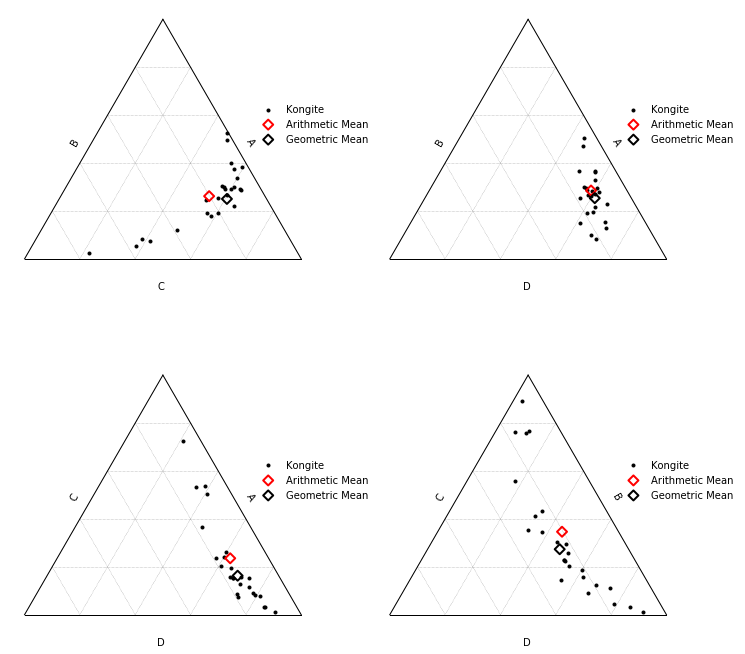

In [10]:
from pyrolite.comp.codata import logratiomean
import itertools

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flat

for columns, a in zip(itertools.combinations(["A", "B", "C", "D"], 3), 
                      ax):
    columns = list(columns)

    df.loc[:, columns].pyroplot.ternary(
        ax=a, 
        color="k", 
        marker=".", 
        label=df.name, 
        no_ticks=True
    )

    df.mean().loc[columns].pyroplot.ternary(
        ax=a,
        edgecolors="red",
        linewidths=2,
        c="none",
        s=50,
        label="Arithmetic Mean",
        no_ticks=True,
    )

    logratiomean(df.loc[:, columns]).pyroplot.ternary(
        ax=a,
        edgecolors="k",
        linewidths=2,
        c="none",
        s=50,
        label="Geometric Mean",
        axlabels=True,
        no_ticks=True,
    )
    a.legend(frameon=False, 
             facecolor=None, 
             loc=(0.8, 0.5))
    a.patch.set_alpha(0)